In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 

# Building the Brain-Model

In [2]:
import pathlib 
dataset_Path = "/Users/Hakkar/Desktop/MultiModal2/Data/Brain"
data_dir = pathlib.Path(dataset_Path)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2471


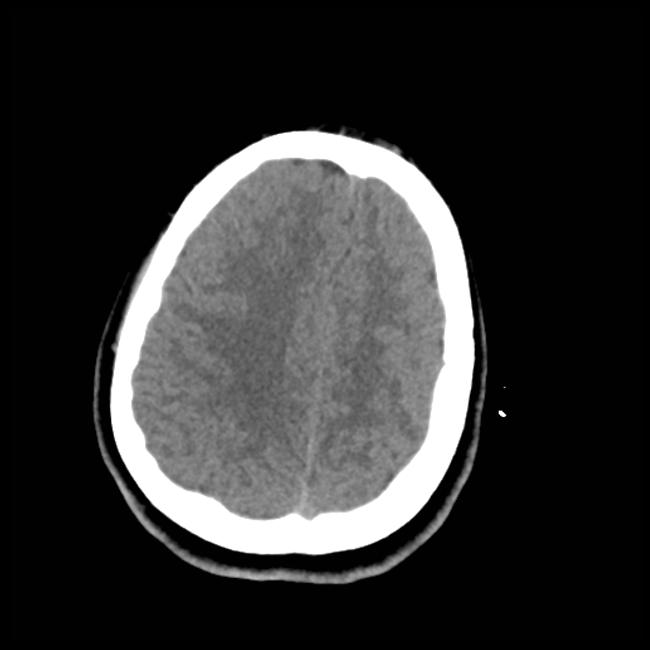

In [4]:
positiv = list(data_dir.glob('Positiv/*'))
PIL.Image.open(str(positiv[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split = 0.2,
subset = "training",
seed = 123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 2471 files belonging to 2 classes.
Using 1977 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split = 0.2,
subset = "validation",
seed = 123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 2471 files belonging to 2 classes.
Using 494 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Negativ', 'Positiv']


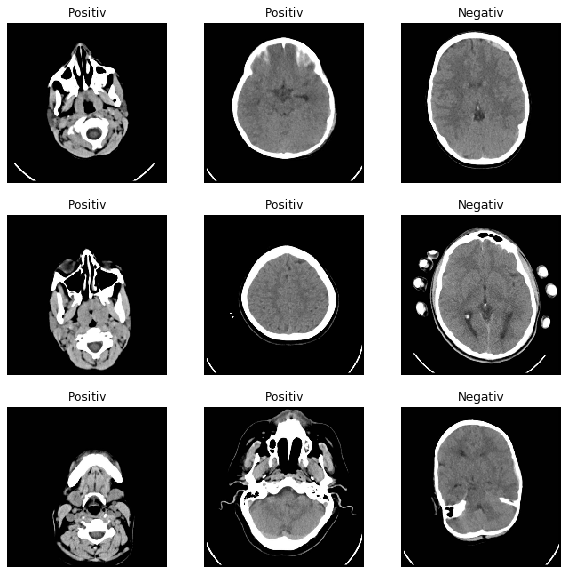

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [13]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
62/62 [==============================] - 50s 799ms/step - loss: 0.4153 - accuracy: 0.8695 - val_loss: 0.2482 - val_accuracy: 0.8968
Epoch 2/10
62/62 [==============================] - 50s 806ms/step - loss: 0.2307 - accuracy: 0.9123 - val_loss: 0.2403 - val_accuracy: 0.9190
Epoch 3/10
62/62 [==============================] - 40s 650ms/step - loss: 0.1571 - accuracy: 0.9429 - val_loss: 0.1672 - val_accuracy: 0.9271
Epoch 4/10
62/62 [==============================] - 39s 634ms/step - loss: 0.0999 - accuracy: 0.9625 - val_loss: 0.1800 - val_accuracy: 0.9312
Epoch 5/10
62/62 [==============================] - 41s 663ms/step - loss: 0.0754 - accuracy: 0.9724 - val_loss: 0.1717 - val_accuracy: 0.9312
Epoch 6/10
62/62 [==============================] - 49s 783ms/step - loss: 0.0516 - accuracy: 0.9805 - val_loss: 0.1605 - val_accuracy: 0.9433
Epoch 7/10
62/62 [==============================] - 41s 667ms/step - loss: 0.0510 - accuracy: 0.9788 - val_loss: 0.1429 - val_accuracy: 0.9372

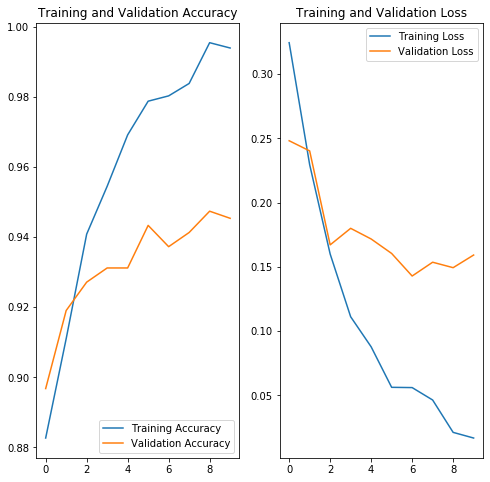

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
62/62 [==============================] - 62s 1s/step - loss: 0.4316 - accuracy: 0.8196 - val_loss: 0.3232 - val_accuracy: 0.8887
Epoch 2/15
62/62 [==============================] - 45s 724ms/step - loss: 0.3189 - accuracy: 0.8692 - val_loss: 0.3156 - val_accuracy: 0.8765
Epoch 3/15
62/62 [==============================] - 45s 719ms/step - loss: 0.3029 - accuracy: 0.8720 - val_loss: 0.2919 - val_accuracy: 0.8745
Epoch 4/15
62/62 [==============================] - 47s 754ms/step - loss: 0.3013 - accuracy: 0.8851 - val_loss: 0.2806 - val_accuracy: 0.8785
Epoch 5/15
62/62 [==============================] - 54s 868ms/step - loss: 0.2730 - accuracy: 0.8958 - val_loss: 0.2663 - val_accuracy: 0.8806
Epoch 6/15
62/62 [==============================] - 50s 805ms/step - loss: 0.2932 - accuracy: 0.8741 - val_loss: 0.2764 - val_accuracy: 0.8745
Epoch 7/15
62/62 [==============================] - 52s 846ms/step - loss: 0.2915 - accuracy: 0.8739 - val_loss: 0.3047 - val_accuracy: 0.8765
Ep

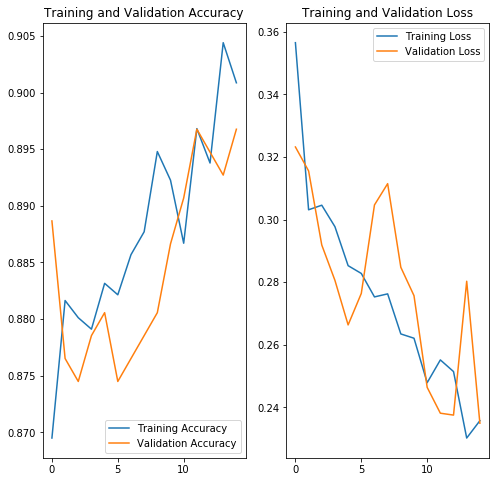

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Building the Model for CT-Bone Images

In [24]:
dataset_Path = "/Users/Hakkar/Desktop/MultiModal2/Data/Bone"
data_dir = pathlib.Path(dataset_Path)


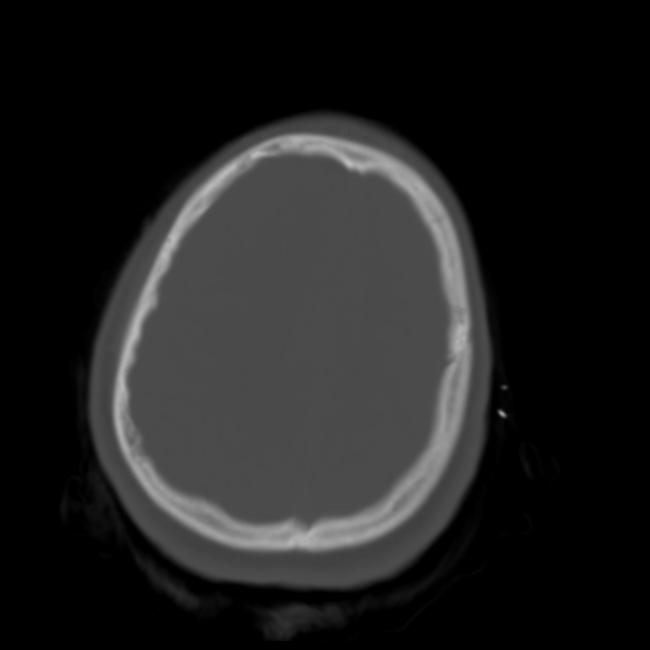

In [25]:
positiv = list(data_dir.glob('Positiv/*'))
PIL.Image.open(str(positiv[0]))

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split = 0.2,
subset = "training",
seed = 123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 2470 files belonging to 2 classes.
Using 1976 files for training.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split = 0.2,
subset = "validation",
seed = 123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 2470 files belonging to 2 classes.
Using 494 files for validation.


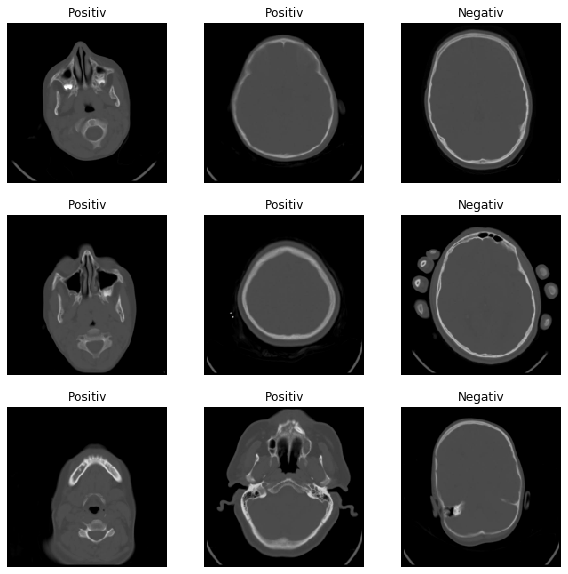

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.6045753


In [32]:
num_classes = 2

model_Bone = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model_Bone.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model_Bone.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [35]:
epochs=10
history = model_Bone.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
62/62 [==============================] - 46s 742ms/step - loss: 0.3669 - accuracy: 0.8799 - val_loss: 0.2646 - val_accuracy: 0.8806
Epoch 2/10
62/62 [==============================] - 40s 641ms/step - loss: 0.2760 - accuracy: 0.8794 - val_loss: 0.2007 - val_accuracy: 0.8988
Epoch 3/10
62/62 [==============================] - 39s 636ms/step - loss: 0.1515 - accuracy: 0.9351 - val_loss: 0.2362 - val_accuracy: 0.8988
Epoch 4/10
62/62 [==============================] - 42s 674ms/step - loss: 0.1080 - accuracy: 0.9602 - val_loss: 0.1449 - val_accuracy: 0.9474
Epoch 5/10
62/62 [==============================] - 47s 751ms/step - loss: 0.0787 - accuracy: 0.9665 - val_loss: 0.1373 - val_accuracy: 0.9413
Epoch 6/10
62/62 [==============================] - 43s 698ms/step - loss: 0.0590 - accuracy: 0.9763 - val_loss: 0.1493 - val_accuracy: 0.9352
Epoch 7/10
62/62 [==============================] - 41s 661ms/step - loss: 0.0469 - accuracy: 0.9869 - val_loss: 0.1097 - val_accuracy: 0.9636

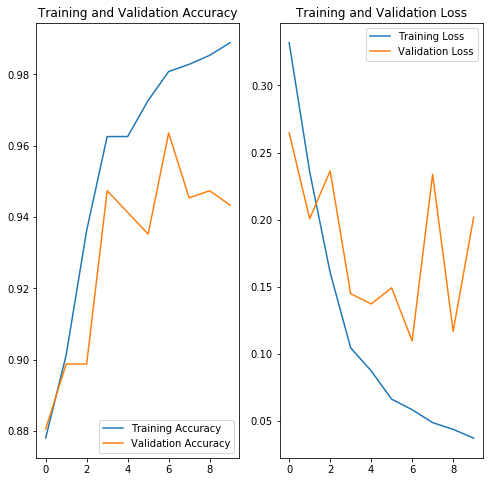

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [38]:
model_Bone = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [39]:
model_Bone.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model_Bone.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [41]:
epochs = 15
history = model_Bone.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
62/62 [==============================] - 52s 844ms/step - loss: 0.4131 - accuracy: 0.8403 - val_loss: 0.3220 - val_accuracy: 0.8745
Epoch 2/15
62/62 [==============================] - 49s 798ms/step - loss: 0.3290 - accuracy: 0.8757 - val_loss: 0.3070 - val_accuracy: 0.8745
Epoch 3/15
62/62 [==============================] - 49s 782ms/step - loss: 0.3034 - accuracy: 0.8749 - val_loss: 0.2964 - val_accuracy: 0.8745
Epoch 4/15
62/62 [==============================] - 48s 776ms/step - loss: 0.2918 - accuracy: 0.8880 - val_loss: 0.2804 - val_accuracy: 0.8745
Epoch 5/15
62/62 [==============================] - 54s 872ms/step - loss: 0.3120 - accuracy: 0.8741 - val_loss: 0.2780 - val_accuracy: 0.8745
Epoch 6/15
62/62 [==============================] - 57s 917ms/step - loss: 0.2902 - accuracy: 0.8772 - val_loss: 0.2690 - val_accuracy: 0.8745
Epoch 7/15
62/62 [==============================] - 48s 769ms/step - loss: 0.2913 - accuracy: 0.8659 - val_loss: 0.2745 - val_accuracy: 0.8745

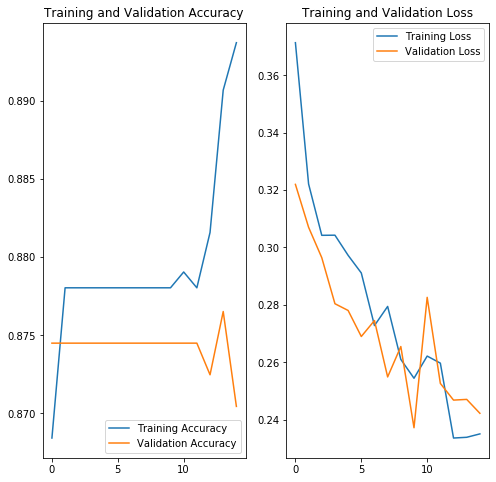

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Ensemble the Brain-Leaner and the Bone-Learner 

In [58]:
BrainPos = '/Users/Hakkar/Desktop/HoldOut/BrainPos/'
BonePos = '/Users/Hakkar/Desktop/HoldOut/BonePos/'
BrainNeg = '/Users/Hakkar/Desktop/HoldOut/BrainNeg/'
BoneNeg = '/Users/Hakkar/Desktop/HoldOut/BoneNeg/'

BrainPosConf = []
BonePosConf = []
BrainNegConf = []
BoneNegConf = []

dirs = os.listdir(BrainPos)
for files in dirs:
    pathBrain = '' + BrainPos + files + ''
    pathBone = '' + BonePos + files + ''
    
    test_dir = pathlib.Path(pathBrain)
    
    try:
        imgBrain = keras.preprocessing.image.load_img(
        test_dir, target_size=(img_height, img_width)
        )
        print(pathBrain)
    except:
        pass
    
    img_array = keras.preprocessing.image.img_to_array(imgBrain)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    if class_names[np.argmax(score)] == "Negativ":
        number = 1- np.max(score)
        BrainPosConf.append(number)
    else:
        BrainPosConf.append(np.max(score))
     
    #BONE PREDICTION
    test_dir = pathlib.Path(pathBone)
    
    try:
        imgBone = keras.preprocessing.image.load_img(
        test_dir, target_size=(img_height, img_width)
        )
        print(pathBone)
    except:
        pass
    
    img_array = keras.preprocessing.image.img_to_array(imgBone)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model_Bone.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    if class_names[np.argmax(score)] == "Negativ":
        number = 1- np.max(score)
        BonePosConf.append(number)
    else:
        BonePosConf.append(np.max(score))
   
    
print(BrainPosConf)
print(BonePosConf)
    

/Users/Hakkar/Desktop/HoldOut/BrainPos/825.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/825.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/775.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/775.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/909.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/909.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/1094.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/1094.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/717.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/717.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/1042.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/1042.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/11524.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/11524.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/491.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/491.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/872.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/872.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/1062.jpg
/Users/Hakkar/Desktop/HoldOut/BonePos/1062.jpg
/Users/Hakkar/Desktop/HoldOut/BrainPos/521.jpg
/Users/Hakkar

In [59]:
dirs = os.listdir(BoneNeg)
for files in dirs:
    pathBrain = '' + BrainNeg + files + ''
    pathBone = '' + BoneNeg + files + ''
    
    test_dir = pathlib.Path(pathBrain)
    
    try:
        imgBrain = keras.preprocessing.image.load_img(
        test_dir, target_size=(img_height, img_width)
        )
        print(pathBrain)
    except:
        pass
    
    img_array = keras.preprocessing.image.img_to_array(imgBrain)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    if class_names[np.argmax(score)] == "Positiv":
        number = 1- np.max(score)
        BrainNegConf.append(number)
    else:
        BrainNegConf.append(np.max(score))
     
    #BONE PREDICTION
    test_dir = pathlib.Path(pathBone)
    
    try: 
        imgBone = keras.preprocessing.image.load_img(
        test_dir, target_size=(img_height, img_width)
        )
        print(pathBone)
    except:
        pass
    
    img_array = keras.preprocessing.image.img_to_array(imgBone)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model_Bone.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    if class_names[np.argmax(score)] == "Positiv":
        number = 1- np.max(score)
        BoneNegConf.append(number)
    else:
        BoneNegConf.append(np.max(score))
print(BrainNegConf)
print(BoneNegConf)

/Users/Hakkar/Desktop/HoldOut/BrainNeg/9724.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/9724.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/8210.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/8210.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/7519.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/7519.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/8010.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/8010.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/5022.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/5022.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/5814.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/5814.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/686.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/686.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/7616.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/7616.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/7414.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/7414.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/5217.jpg
/Users/Hakkar/Desktop/HoldOut/BoneNeg/5217.jpg
/Users/Hakkar/Desktop/HoldOut/BrainNeg/9428.jpg
/Use

In [60]:
resultPos = []
resultNeg = []
for x in range(0, len(BrainPosConf)):
    resultPos.append((((BrainPosConf[x] + BonePosConf[x])/2)*100))
    
for x in range(0, len(BrainNegConf)):
    resultNeg.append((((BrainNegConf[x] + BoneNegConf[x])/2)*100))


In [61]:
print(resultPos)
print(resultNeg)

[99.75013732910156, 99.75013732910156, 99.97658729553223, 79.7925591468811, 99.99318718910217, 99.83526468276978, 99.99911785125732, 93.1307852268219, 98.76489639282227, 99.98508095741272, 99.99777674674988, 99.99909996986389, 99.91379976272583, 99.98819828033447, 99.98408555984497, 99.8807966709137]
[24.057790637016296, 24.057790637016296, 39.116692543029785, 53.52277457714081, 3.9606422185897827, 25.41261315345764, 5.332168936729431, 9.943363070487976, 46.5371698141098, 39.131784439086914, 50.137099623680115, 47.13324308395386, 37.19457387924194, 20.57930827140808, 16.265684366226196, 15.922126173973083]


In [63]:
hemorrhagePosAcc = 0
hemorrhageNegAcc = 0
AccOverall = 0

for x in resultPos:
    hemorrhagePosAcc += x

for x in resultNeg: 
    hemorrhageNegAcc += x 

tmp = len(resultNeg) + len(resultPos)
print(tmp)

hemorrhagePosAcc = hemorrhagePosAcc/len(resultPos)
hemorrhageNegAcc = hemorrhageNegAcc/len(resultNeg)
AccOverall = (hemorrhageNegAcc+hemorrhagePosAcc)/2

#hemorrhagePosAcc = hemorrhagePosAcc/len(resultPos)
print("Accuracy of Positve Hemorrhage is: " + str(hemorrhagePosAcc))
print("Accuracy of Negative Hemorrhage is: " + str(hemorrhageNegAcc))
print("Accuracy of Overall Model Performance: " + str(AccOverall))



32
Accuracy of Positve Hemorrhage is: 98.17134439945221
Accuracy of Negative Hemorrhage is: 28.64405158907175
Accuracy of Overall Model Performance: 63.40769799426198
